# Dataset introduction

The dataset chosen for this project is a celeberity dataset. Through this dataset we will be trying to generate faces and with certain attributes like smiling, young, male or female and so on.

We have 4 different files as described below:

1. **img_align_celeba.zip**: All the face images
2. **list_eval_partition.csv**: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
3. **list_bbox_celeba.csv**: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
4. **list_landmarks_align_celeba.csv**: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
5. **list_attr_celeba.csv**: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Neural_Project_Celeba/

In [1]:
#Importing zipfile for unzipping the dataset file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import load_img
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
# from google.colab import drive
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.models import Model
from tensorflow.keras.layers import Dropout, Lambda, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import concurrent.futures
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [9]:
# Mounting Google Drive
drive.mount('/content/drive',force_remount=True)

# drive.flush_and_unmount()

Mounted at /content/drive


In [10]:
# Navigating to the directory containing the zip file
%cd /content/drive/MyDrive/Neural_Project_Celeba/

# Unzipping the file
!unzip img_align_celeba.zip

/content/drive/MyDrive/Neural_Project_Celeba


The below code is for the file where the attributes of each of the image is given and the corresponding values, where 1 indicates a Yes and -1 ondicates a No.

In [2]:
df_list_attr = pd.read_csv('list_attr_celeba.csv')
# df_list_attr = pd.read_csv('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/list_attr_celeba.csv')
df_list_attr.set_index('image_id', inplace=True)
df_list_attr.replace(to_replace=-1, value=0, inplace=True)  # replacing all the attributes of -1 by 0
df_list_attr.shape

(202599, 40)

In [3]:
#Displaying different attributes of the images. In total, there are 40 attributes for each image.
df_list_attr

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


The image below plotted shows different details, and it appears based on whether the details have a '1', meaning 'Yes'. This makes it easier to understand and learn about the different details in the file.

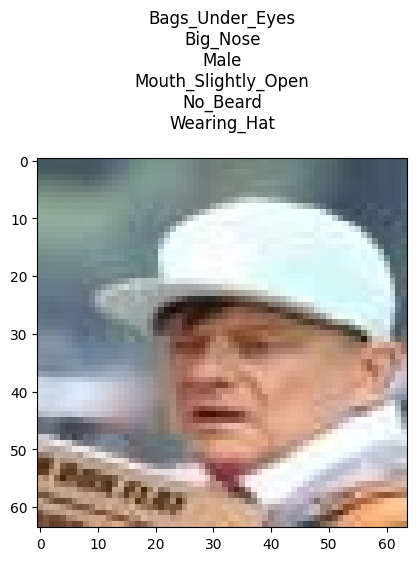

In [4]:
label = ''
# img = load_img('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/054810.jpg')
img = load_img('img_align_celeba/054810.jpg')
row_index = df_list_attr.index.get_loc('054810.jpg')

for col in df_list_attr.columns:
    if df_list_attr.loc['054810.jpg', col] == 1:
        label += col + '\n'

plt.imshow(img)
plt.title(label)
plt.show()

The below code is of the file list_eval_partition.csv. This file contains the partition of the data in training, validation and testing dataset.

In [5]:
#Overview of list_eval_partition.csv
df_partition_list = pd.read_csv('list_eval_partition.csv')
# df_partition_list = pd.read_csv('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/list_eval_partition.csv')
df_partition_list.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [6]:
#Partition columns is defined as follows: 0 for training, 1 for validation and 2 for testing dataset
df_partition_list.groupby('partition').size().sort_index()

partition
0    162770
1     19867
2     19962
dtype: int64

In [18]:
directory_path = '/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/'
# directory_path = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'  ----------> Commented by Rashi, uncomment this if using colab
image_list = os.listdir(directory_path)
for image in image_list:

    # Construct the full file path
    image_path = os.path.join(directory_path, image)

    # Open the image using Pillow
    image = Image.open(image_path)

    # Resize the image to (64, 64)
    resized_image = image.resize((64, 64))

    # Save the resized image, overwriting the original file
    resized_image.save(image_path)

In [7]:
#Reshaped the image
img = load_img('img_align_celeba/081169.jpg')
# img = load_img('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/134526.jpg')
img_array = np.array(img)
print("Image shape:", img_array.shape)

Image shape: (64, 64, 3)


In [8]:
def parse_image(data):
    img = tf.io.read_file(data)
    img = tf.image.decode_jpeg(img, channels=3)
    
    shapes = tf.shape(img)
    h, w = shapes[-3], shapes[-2]
    small = tf.minimum(h, w)
    
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.resize_with_crop_or_pad(img, small, small) 
    img = tf.image.resize(img, [64, 64], antialias=True)
    return img

def plot_image(images): 
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        
def plot_reconstructed(original, reconstructed): 
    images = np.concatenate([original, reconstructed])
    fig = plt.figure(figsize=(10, 5))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 6), axes_pad=0, share_all=True)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()

In [32]:
#Splitting data into training, validation and testing dataset
#df_partition_list contains the partition of test,training and validation datasets

directory_path = './img_align_celeba/'
batch_size = 128

def load_image(file_path):
    im = load_img(file_path)
    return np.array(im)

with concurrent.futures.ThreadPoolExecutor() as executor:
    train_data_list = list([directory_path + i for i in df_partition_list[df_partition_list['partition'] == 0]['image_id']])
    validation_data_list = list([directory_path + i for i in df_partition_list[df_partition_list['partition'] == 1]['image_id']])
    test_data_list = list([directory_path + i for i in df_partition_list[df_partition_list['partition'] == 2]['image_id']])
        
    train_data = tf.data.Dataset.from_tensor_slices(train_data_list)
    validation_data = tf.data.Dataset.from_tensor_slices(validation_data_list)
    test_data = tf.data.Dataset.from_tensor_slices(test_data_list)
    
    
train_ds = train_data.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(len(train_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = validation_data.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(len(validation_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_data.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(len(test_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# retrieve a batch of images
train_batch = next(iter(train_ds))
    
# training_data = np.asarray(training_dataset).astype('float32')
# validation_data = np.asarray(validation_dataset).astype('float32')
# test_data = np.asarray(test_dataset).astype('float32')

# training_data = training_data / 255.0
# validation_data = validation_data / 255.0
# test_data = test_data / 255.0

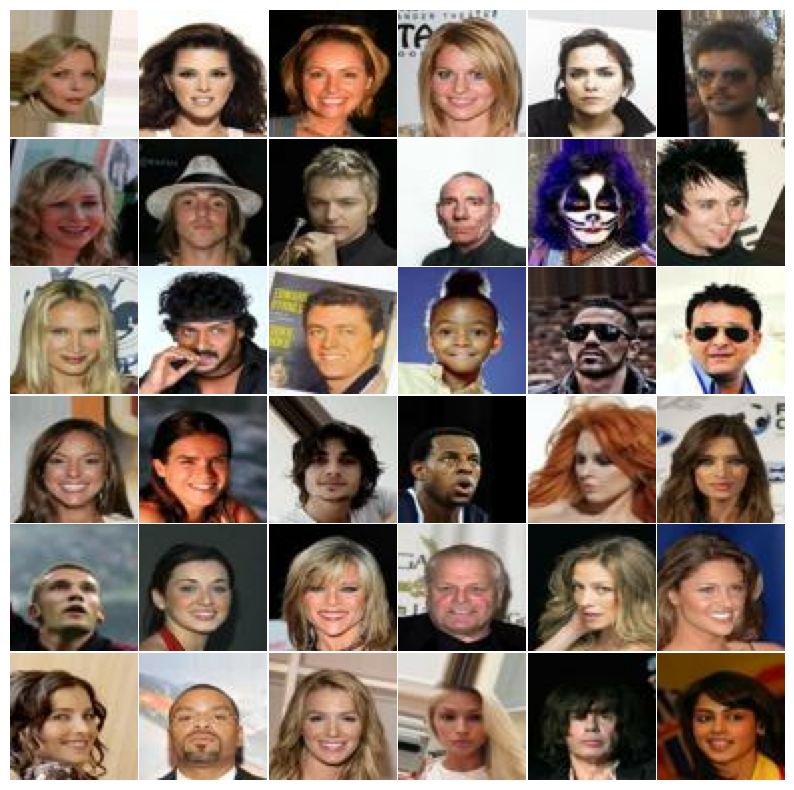

In [10]:
plot_image(train_batch.numpy())

In [11]:
#Building encoder
latent_dim = 100
input_shape = (64,64,3)

encoder_input = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (4, 4), strides=2, padding='same')(encoder_input)
# x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(encoder_input)
x = BatchNormalization(axis=-1)(x) 
x = LeakyReLU(alpha=0.3)(x)

x = Conv2D(64, (4, 4), strides=2, padding='same')(x)
# x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x) 
x = LeakyReLU()(x)

x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
# x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x) 
x = LeakyReLU()(x)

x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
# x = Conv2D(256, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x) 
x = LeakyReLU()(x)

convolution_shape = keras.backend.int_shape(x)

x = Flatten(data_format='channels_last')(x)

# Parameters for the VAE
z_mean = Dense(latent_dim, activation=None)(x)
z_log_var = Dense(latent_dim, activation=None)(x)

# class SamplingLayer(layers.Layer):
#     def call(self, inputs, **kwargs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.random.normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon
# # Usage
# z = SamplingLayer()([z_mean, z_log_var])

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(1, 100), mean=0., stddev=0.1)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Encoder output
# encoder_output = Dense(latent_dim, activation='linear', name='encoder_output')(x)

# Create the encoder model
encoder_model = Model(encoder_input, [z_mean, z_log_var, z], name='encoder_model')
# encoder_model = Model(encoder_input, [z_mean, z_log_var, encoder_output], name='encoder_model')

encoder_model.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           1568      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)           0         ['batch_normalizat

In [12]:
# Decoder
decoder_input = Input(shape = (latent_dim), name = 'decoder_input')
x = Dense(convolution_shape[1] * convolution_shape[2] * convolution_shape[3], activation = 'relu')(decoder_input)
x = Reshape((convolution_shape[1], convolution_shape[2], convolution_shape[3]))(x)

x = UpSampling2D((2,2), data_format='channels_last', interpolation='nearest')(x) 
x = Conv2D(128,(3, 3), padding='same', strides=(1,1))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = UpSampling2D((2,2))(x) 
x = Conv2D(64,(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = UpSampling2D((2,2))(x) 
x = Conv2D(32,(3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = UpSampling2D((2,2))(x) 
x = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

decoder_model = Model(decoder_input, x, name = 'decoder')
    
# x = Dense(convolution_shape[1] * convolution_shape[2] * convolution_shape[3], activation = 'relu')(decoder_input)

# # reshaping to the last convolution layer of encoder, so that we can upsacle to the original shape
# x = Reshape((convolution_shape[1], convolution_shape[2], convolution_shape[3]))(x)

# # Conv2DTranspose to perform the reverse of convolution layers from encoder
# x = Conv2DTranspose(64, kernel_size = 3, padding = 'same', activation = 'relu')(x)

# #Added to check
# x = Conv2DTranspose(32, kernel_size = 3, padding = 'same', activation = 'relu')(x)

# # another Conv2DTranspose just for fun, but with sigmoid activation
# x = Conv2DTranspose(3, kernel_size = 3, padding = 'same', activation = 'sigmoid', name = 'decoder_output')(x)

# # create the decoder model
# decoder_model = Model(decoder_input, x, name = 'decoder')


decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 256)         0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 128)         512       
 chNormalization)                                          

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
    # def __init__(self, preprocesser, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.alpha = 1.8
        self.beta = 10
        # self.preprocessor = preprocesser
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
        
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = self.alpha * reconstruction_loss + self.beta * kl_loss
            # total_loss = reconstruction_loss + kl_loss           
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
    # def forward(self, data):
    #     preprocessed = self.preprocesser(data)
    #     z_mean, z_log_var, z = self.encoder(preprocessed)
    #     reconstruction = self.decoder(z)
    #     return z_mean, z_log_var,reconstruction

    # def train_step(self, data):
    #     with tf.GradientTape() as tape:
    #         z_mean, z_log_var, reconstruction = self.forward(data)
    #         # z_mean, z_log_var, z = self.encoder(data)
    #         # reconstruction = self.decoder(z)
    #         reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
    #             # tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
    #         kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    #         kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    #         total_loss = self.alpha * reconstruction_loss + self.beta * kl_loss
    #         # total_loss = reconstruction_loss + kl_loss           
        
    #     grads = tape.gradient(total_loss, self.trainable_weights)
    #     self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    #     self.total_loss_tracker.update_state(total_loss)
    #     self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    #     self.kl_loss_tracker.update_state(kl_loss)
    #     return {
    #         "loss": self.total_loss_tracker.result(),
    #         "reconstruction_loss": self.reconstruction_loss_tracker.result(),
    #         "kl_loss": self.kl_loss_tracker.result()
    #     }
        
    def call(self, data):
        # data = self.preprocessor(data)
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = self.alpha * reconstruction_loss + self.beta * kl_loss
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction": reconstruction
        }

In [14]:
# preprocesser = preprocesser()
# vae = VAE(preprocesser, encoder_model, decoder_model)
vae = VAE(encoder_model, decoder_model)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))
vae_history = vae.fit(train_ds, epochs=20, batch_size=batch_size, validation_data=(val_ds, None))

Epoch 1/20


2023-12-08 19:28:12.951342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


2544/2544 [==============================] - 221s 86ms/step - loss: 3982.9861 - reconstruction_loss: 2125.4326 - kl_loss: 0.4591 - val_total_loss: 3758.9277 - val_reconstruction_loss: 2086.2642 - val_kl_loss: 0.3652
Epoch 2/20
2544/2544 [==============================] - 229s 90ms/step - loss: 3727.5125 - reconstruction_loss: 2063.0144 - kl_loss: 0.3605 - val_total_loss: 3717.0505 - val_reconstruction_loss: 2063.1172 - val_kl_loss: 0.3442
Epoch 3/20
2544/2544 [==============================] - 238s 93ms/step - loss: 3696.0659 - reconstruction_loss: 2048.9468 - kl_loss: 0.3369 - val_total_loss: 3700.3801 - val_reconstruction_loss: 2053.9868 - val_kl_loss: 0.3204
Epoch 4/20
2544/2544 [==============================] - 236s 93ms/step - loss: 3679.5904 - reconstruction_loss: 2042.2614 - kl_loss: 0.3289 - val_total_loss: 3692.7227 - val_reconstruction_loss: 2049.6609 - val_kl_loss: 0.3334
Epoch 5/20
2544/2544 [==============================] - 234s 92ms/step - loss: 3674.2114 - reconstructi

In [15]:
def display_history(history):
    
    fig=plt.figure(figsize=(20,5))

    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history['reconstruction_loss'])
    plt.plot(history.history['val_reconstruction_loss'])
    plt.title('reconstruction_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history['kl_loss'])
    plt.plot(history.history['val_kl_loss'])
    plt.title('kl_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

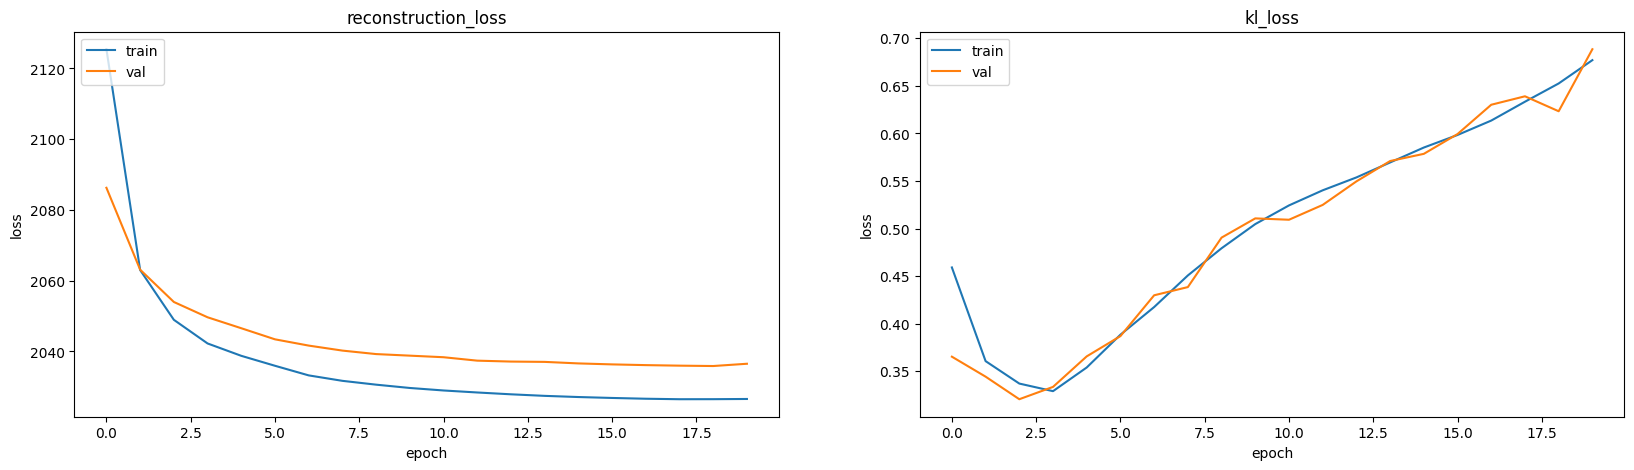

In [16]:
display_history(vae_history)

1/1 [==============================] - 0s 39ms/step


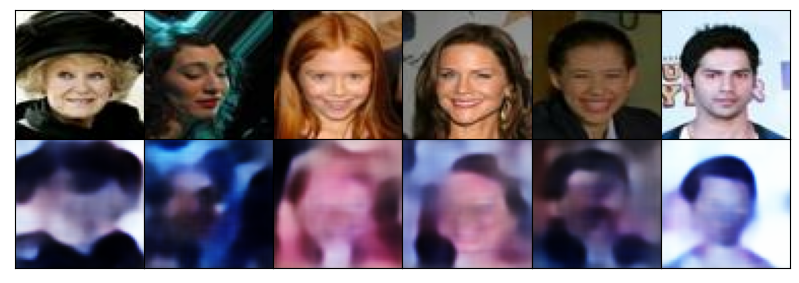

In [64]:
test_ds1 = tf.data.Dataset.from_tensor_slices(test_data_list[:6])

test_ds2 = test_ds1.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds2 = test_ds2.cache().batch(6).prefetch(buffer_size=tf.data.AUTOTUNE)
test_batch = next(iter(test_ds2))

# # Reconstructed images
encoded_data  = vae.encoder.predict(test_ds2)
decoded_data  = vae.decoder.predict(encoded_data[0])
plot_reconstructed(test_batch.numpy(),decoded_data)

2/2 [==============================] - 0s 10ms/step


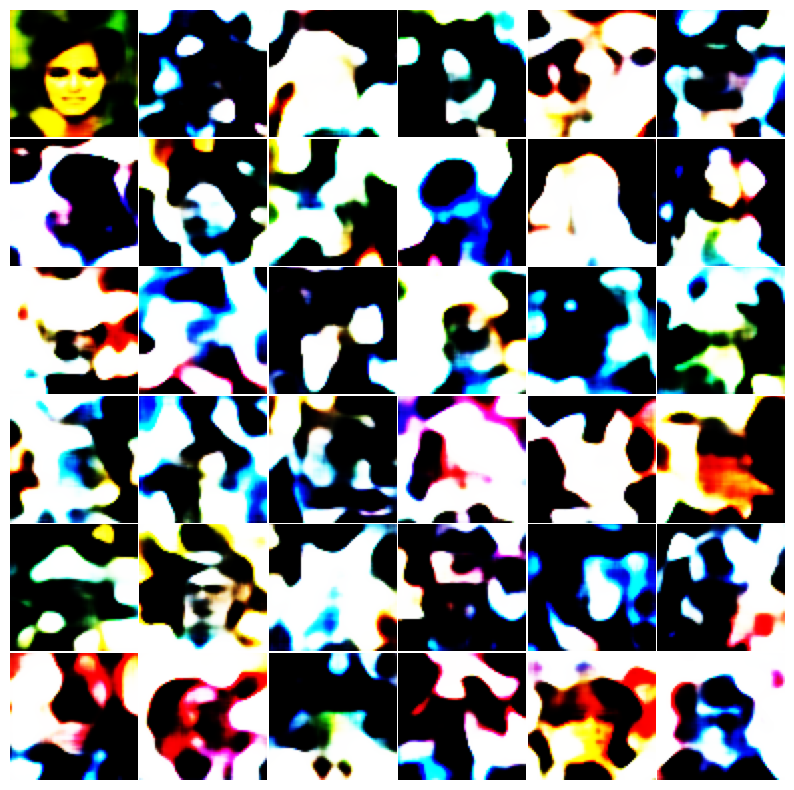

In [51]:
# Faces generated from random noise
random_latent_vectors = tf.random.normal(shape=(36,latent_dim))
random_generated = vae.decoder.predict(random_latent_vectors)
plot_image(random_generated)

1/1 [==============================] - 0s 15ms/step


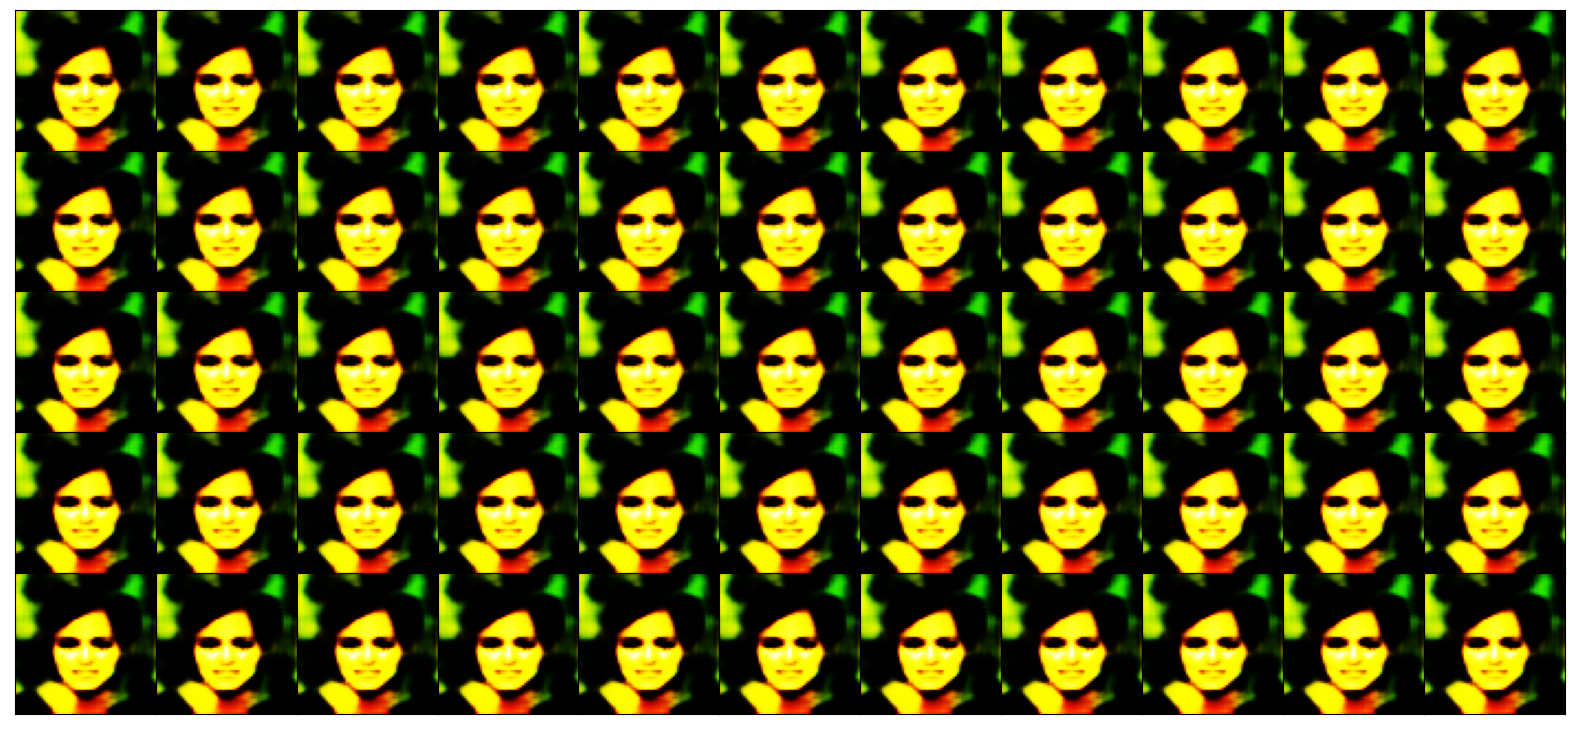

In [52]:
def plot_latent_space(n=5): 
    output_list = []
    for i in range(n):
        z1 = tf.random.normal([1,latent_dim],0.0 ,1.0)
        z2 = tf.random.normal([1,latent_dim],0.0 ,1.0)
        for j in range(11):
            z_in = (j/10) * z1 + (1 - (j/10)) * z2
            output = vae.decoder.predict(z_in)
            output_list.append(output[0])
            
    images = np.array(output_list)
    
    fig = plt.figure(figsize=(20, n*2))
    grid = ImageGrid(fig, 111, nrows_ncols=(n, 11), axes_pad=0, share_all=True)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()
    
plot_latent_space(5)

In [13]:
class CustomLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded, z_mean, z_log_var):
        alpha = 1.8
        beta = 10
        
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)

        # Reconstruction loss using binary_crossentropy
        recon_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        loss = alpha * recon_loss + beta * kl_loss

        return loss

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mean = inputs[2]  # Assuming z_mean is the third input
        z_log_var = inputs[3]  # Assuming z_log_var is the fourth input

        loss = self.vae_loss(x, z_decoded, z_mean, z_log_var)
        self.add_loss(loss, inputs=inputs)
        return x


# Assuming encoder_input, z_decoded, z_mean, and z_log_var are your tensors
z_decoded = decoder_model(z)
y = CustomLayer()([encoder_input, z_decoded, z_mean, z_log_var])



  1/312 [..............................] - ETA: 11s

624/624 [==============================] - 8s 13ms/step


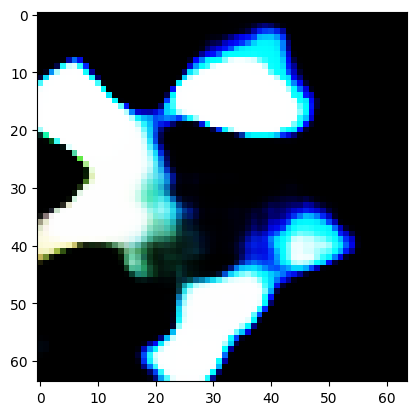

In [53]:
def sample_latent_space(z_mean, z_log_var):
    batch, latent_dim = z_mean.shape
    epsilon = np.random.normal(size=(batch, latent_dim))
    return z_mean + np.exp(0.5 * z_log_var) * epsilon

def get_z_mean_z_log_var(input_image):
    z_mean, z_log_var, _ = vae.encoder.predict(input_image)
    return z_mean, z_log_var


z_mean_value, z_log_var_value = get_z_mean_z_log_var(test_ds)

latent_vector = sample_latent_space(z_mean_value, z_log_var_value)

generated_image = vae.decoder.predict(latent_vector)

plt.imshow(generated_image[0])
plt.show()

In [21]:
# Discriminator model
discriminator_input = Input(shape=(latent_dim,), name='discriminator_input')
x = Dense(64, activation = 'relu')(discriminator_input)
x = Dense(32)(x)
discriminator_output = Dense(1, activation='sigmoid', name='discriminator_output')(x)

discriminator_model = Model(discriminator_input, discriminator_output, name='discriminator_model')

In [22]:
discriminator_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
discriminator_model.summary()

Model: "discriminator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 32)]              0         
 Layer)                                                          
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 discriminator_output (Dens  (None, 1)                 33        
 e)                                                              
                                                                 
Total params: 4225 (16.50 KB)
Trainable params: 4225 (16.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
aae_output = discriminator_model(encoder_model(encoder_input))
aae = Model(inputs=encoder_input, outputs=[vae(encoder_input), aae_output])
aae.compile(optimizer='adam', loss={'vae': 'CustomLayer()', 'discriminator_model': binary_crossentropy})
aae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder_model (Functional)  [(None, 32),                 2518531   ['encoder_input[0][0]']       
                              (None, 32),                 2                                       
                              (None, 32)]                                                         
                                                                                                  
 model (Functional)          (None, 64, 64, 3)            2550368   ['encoder_input[0][0]']       
                                                          3                                 

In [24]:
epochs = 10
batch_size =32 

for epoch in range(epochs):

    print("Starting vae loss")
    # Train the VAE
    vae_loss=vae.fit(training_data, None, batch_size = 32)

    print("Starting generated_samples")
    # Generate fake samples using the VAE
    generated_samples = vae.predict(training_data)

    # Create labels for real and generated samples
    print("Starting real and fake labels")
    real_labels = np.ones((len(training_data), 1))
    fake_labels = np.zeros((len(training_data), 1))

    print("Starting discriminator loss")
    # Train the discriminator with real and generated samples
    discriminator_loss = discriminator_model.fit(np.concatenate([training_data, generated_samples]),np.concatenate([real_labels, fake_labels]))

    # Print or log the losses for monitoring
    print(f'Epoch {epoch + 1}/{epochs}, VAE Loss: {vae_loss["vae"]}, Discriminator Loss: {discriminator_loss}')

Starting vae loss
5087/5087 [==============================] - 1149s 226ms/step - loss: 0.5189
Starting generated_samples
5087/5087 [==============================] - 12s 2ms/step
Starting real and fake labels
Starting discriminator loss


: 